# Import and functions

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage
import pandas as pd

%matplotlib inline

In [54]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
# from StimulusnResponse import SSG
from Spike_Generation import SG
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL

In [55]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

# Set Parameter

In [56]:
m = 16.416565
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

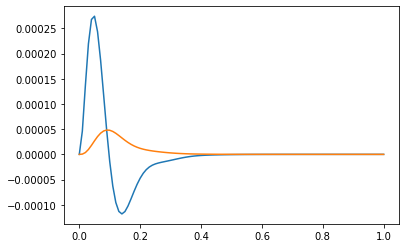

In [57]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

In [58]:
tot = 300
tAxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(tAxis))
mu, sigma = 0, 1
for i in range(len(tAxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

In [59]:
amp = 2
mean = 10
baseOutput = np.convolve(np.hstack((np.zeros(len(k_E)), x))*amp+mean, -k_E, 'full')[len(k_E):len(k_E)+len(x)]

In [60]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

theta_star = 0

r = baseOutput
r = NL(r, np.mean(r) + theta_star*np.std(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
baseXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

In [61]:
tv = ndimage.gaussian_filter1d(LPOU, order=1, sigma=1)/dt
#assign states
state_num = 6
xstate = EqualState(LPOU, state_num)[0]
tvstate = EqualState(tv, state_num)[0]

baserstate = SG(baseOutput, dt, theta_star, 10, 2)
timeshift, baseMI = MIfunc(baserstate, xstate, dt, window, perSpike = True)

# +SFB

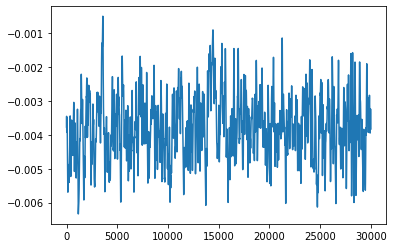

In [62]:
plt.plot(baseOutput)

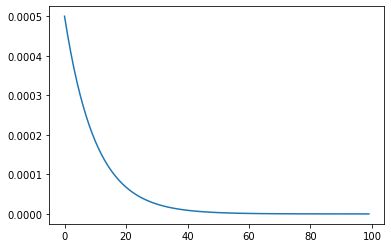

In [63]:
tau_P = 0.1 #s
sigma_b = 0.0005
expDecay = np.exp(-np.arange(0,1,dt)/tau_P)*sigma_b
plt.plot(expDecay)

In [64]:
def SFB(input, expDecay, theta):
    h = input.copy()
    rstate = np.zeros_like(baseOutput)
    for i in range(len(h)):
        while h[i] > theta:
            rstate[i] += 1
            h[i:min(i+len(expDecay),len(h))] -= expDecay[:min(len(expDecay),len(h)-i)]
    return rstate, h

In [65]:
def SFB2(input, expDecay, theta):
    h = input.copy()
    rstate = np.zeros_like(baseOutput)
    theta = theta*np.ones_like(baseOutput)
    for i in range(len(h)):
        while h[i] > theta[i]:
            rstate[i] += 1
            theta[i:min(i+len(expDecay),len(h))] += expDecay[:min(len(expDecay),len(h)-i)]
    return rstate, theta

# DCCM

In [66]:
contrast_list = np.array([0.05,0.1,0.15,0.2,0.3])
DCCM_rstate = [0]*len(contrast_list)
# DCCM_rstate = [0]*len(contrast_list)
record_theta = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    output = np.convolve(np.hstack((np.zeros(len(k_E)), x))*contrast_list[i]*mean+mean, -k_E, 'full')[len(k_E):len(k_E)+len(x)]
    theta = np.mean(output)+theta_star*np.std(output)
    # DCCM_rstate1[i], _ = SFB(output, expDecay, theta) # GC after rectifier
    DCCM_rstate[i], record_theta[i] = SFB2(output, expDecay, theta) # GC after rectifier

(5000.0, 6000.0)

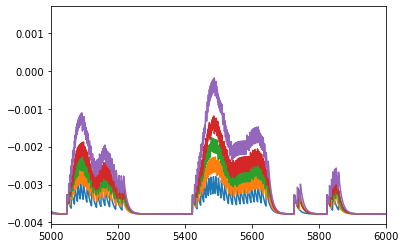

In [67]:
for i in range(len(contrast_list)):
    plt.plot(record_theta[i])
plt.xlim(5000,6000)

(5000.0, 6000.0)

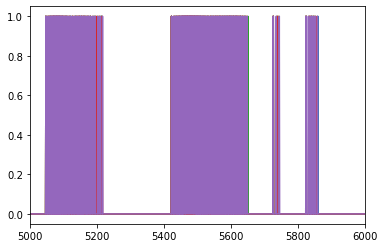

In [68]:
for i in range(len(contrast_list)):
    plt.plot(DCCM_rstate[i])
plt.xlim(5000,6000)

### STA

In [69]:
x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

DCCM_Xcorr = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    Xcorr = np.correlate(x, DCCM_rstate[i], 'same') / np.correlate(np.ones_like(x), DCCM_rstate[i], 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    DCCM_Xcorr[i] = Xcorr.copy()

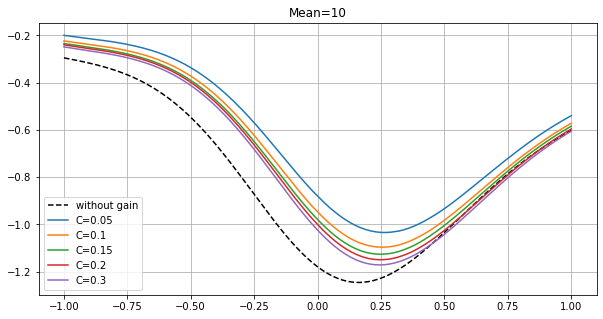

In [70]:
plt.plot(timeaxis,baseXcorr, 'k--', label= 'without gain' )
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_Xcorr[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

### MI

In [71]:
DCCM_MI = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    timeshift, DCCM_MI[i] = MIfunc(DCCM_rstate[i], xstate, dt, window, perSpike = True)

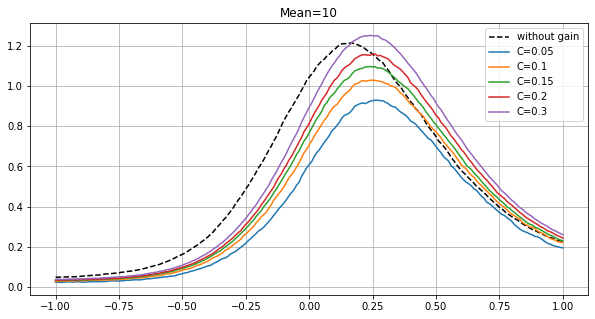

In [72]:
plt.plot(timeaxis,baseMI, 'k--', label= 'without gain' )
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_MI[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

# CCDM

In [81]:

mag_list = np.linspace(0.2,10.,10)
# mag_list = [0.2,0.4,0.7,1,1.3]
CCDM_rstate = [0]*len(mag_list)
for i in range(len(mag_list)):
    output = np.convolve( (np.hstack((np.zeros(len(k_E)), x))*amp+mean)*mag_list[i], -k_E, 'full')[len(k_E):len(k_E)+len(x)]
    theta = np.mean(output)+theta_star*np.std(output)
    CCDM_rstate[i], _ = SFB(output, expDecay, theta) # GC after rectifier

(5000.0, 6000.0)

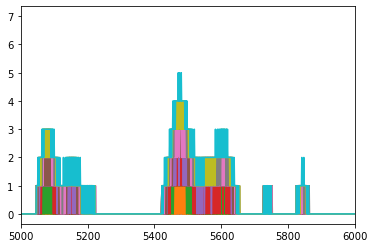

In [82]:
for i in range(len(mag_list)):
    plt.plot(CCDM_rstate[i])
plt.xlim(5000,6000)

### STA

In [83]:
CCDM_Xcorr = [0]*len(mag_list)
for i in range(len(mag_list)):
    Xcorr = np.correlate(x, CCDM_rstate[i], 'same') / np.correlate(np.ones_like(x), CCDM_rstate[i], 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    CCDM_Xcorr[i] = Xcorr.copy()

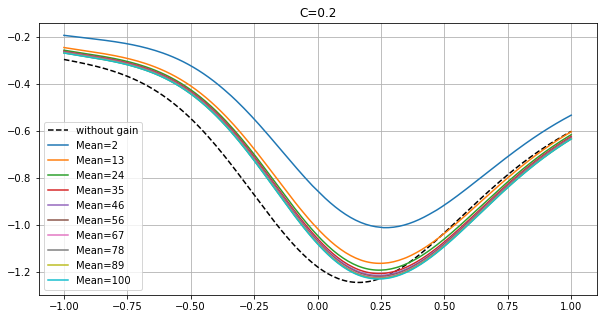

In [84]:
plt.plot(timeaxis,baseXcorr, 'k--', label= 'without gain' )
for i in range(len(mag_list)): 
    plt.plot(timeaxis,CCDM_Xcorr[i], label = 'Mean='+str(round(mag_list[i]*mean)))
plt.legend()
plt.title('C='+str(amp/mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

### MI

In [85]:
CCDM_MI = [0]*len(mag_list)
for i in range(len(mag_list)):
    timeshift, CCDM_MI[i] = MIfunc(CCDM_rstate[i], xstate, dt, window, perSpike = True)

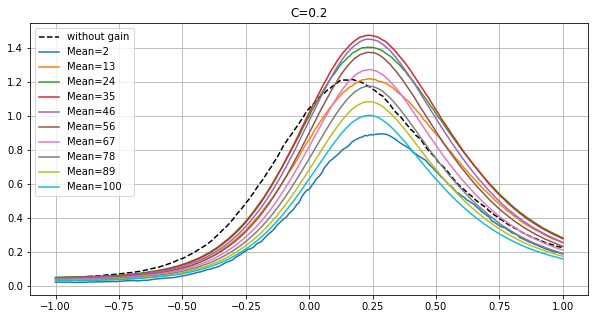

In [86]:
plt.plot(timeaxis,baseMI, 'k--', label= 'without gain' )
for i in range(len(mag_list)): 
    plt.plot(timeaxis,CCDM_MI[i], label = 'Mean='+str(round(mag_list[i]*mean)))
plt.legend()
plt.title('C='+str(amp/mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

# Saving Data

In [87]:
name = 'NGD+SFB'

legend = ['M=10;C='+str(C) for C in [0.05,0.1,1.5,0.2,0.3]]+['C=0.2;M='+str(M) for M in [2,4,7,10,13]]

In [88]:
MI_Data = {}
STA_Data = {}
MI_Data['timeshift'] = timeaxis
STA_Data['timeshift'] = timeaxis

i=0
for MI in DCCM_MI:
    MI_Data[legend[i]] = MI
    i += 1
for MI in CCDM_MI:
    MI_Data[legend[i]] = MI
    i += 1
    
i=0
for Xcorr in DCCM_Xcorr:
    STA_Data[legend[i]] = Xcorr
    i += 1
for Xcorr in CCDM_Xcorr:
    STA_Data[legend[i]] = Xcorr
    i += 1
    

IndexError: list index out of range

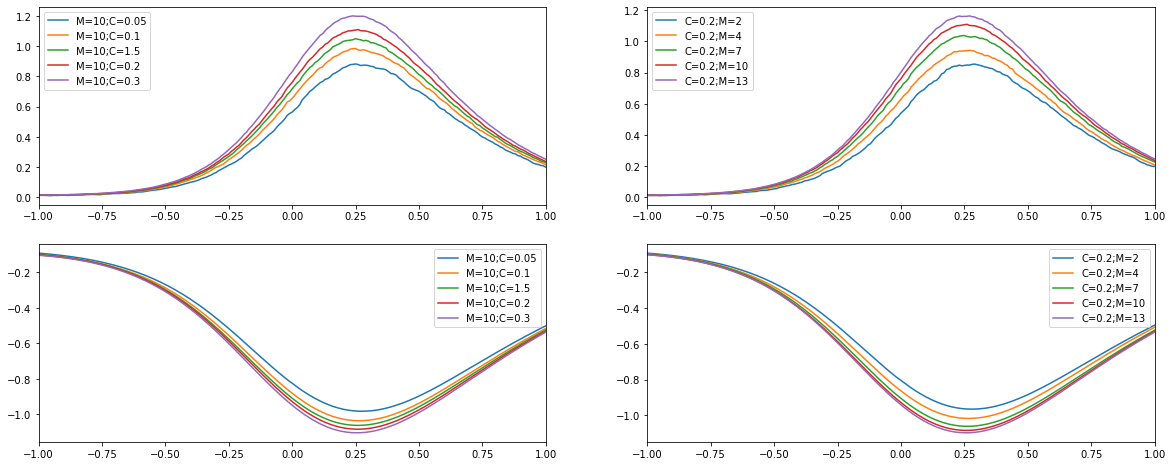

In [ ]:
fig, ax = plt.subplots(2,2)
cmind=0
for i in range(5):
    ax[0,0].plot(MI_Data['timeshift'], MI_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    ax[1,0].plot(MI_Data['timeshift'], STA_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    cmind += 1
cmind=0
for i in np.arange(5,10):
    ax[0,1].plot(MI_Data['timeshift'], MI_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    ax[1,1].plot(MI_Data['timeshift'], STA_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    cmind += 1


for axi in ax.flatten():
    axi.legend()
    axi.set_xlim([-1,1])
fig.set_size_inches(20, 8)

In [ ]:
# MI_data_df = pd.DataFrame(MI_Data)
# STA_data_df = pd.DataFrame(STA_Data)
# with pd.ExcelWriter('D:\\GoogleDrive\\retina\\ContrastPaper\\4OriginPlot\\'+name+'.xlsx') as writer:
#     MI_data_df.to_excel(writer,'MI',float_format='%.6f') # float_format 控制精度
#     STA_data_df.to_excel(writer,'STA',float_format='%.6f') # float_format 控制精度